# Model Training

Using aggregated and condensed headline data

In [1]:
!pip install datasets wandb transformers

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("csv", data_files="/content/drive/MyDrive/jvdm_aggregated_data.csv" )
dataset = dataset.remove_columns([col for col in dataset["train"].column_names if col not in ["Headlines_Condensed", "TrendD+1"]])
dataset = dataset.rename_column("TrendD+1", "labels")

In [5]:
train_test_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [6]:
print(train_dataset[0])
print(test_dataset[0])

{'labels': 0, 'Headlines_Condensed': 'even amazon immune political economic pressure pret manger bring full labelling teenager death aston martin ipo disappoints luxury carmaker value falls san marino plans ask imf bailout bolster banks high stakes cannabis capitalists seek funds drive drug trade greed led australian steal dead people noel edmonds fails get lloyds bank black horse ads banned italian deputy pm threatens sue eu boss budget criticism number us companies disclosing donations reaches new boris johnson take aid give elephants really shell approves usd bn liquefied natural gas project canada star wars last jedi abuse blamed russian trolls agendas raises minimum wage uk employees ikea says goodbye plastic straws display london design museum primera air collapse rights refund toyota hard brexit would halt plant bmw warns mini caa not rescue stranded passengers house prices fall stamp duty fears bite business live euro hit row happened royal mail share price sinks profit warning

In [7]:
label_list = dataset["train"].unique("labels")
num_labels = len(label_list)

### Load tokenizer

In [8]:
from transformers import AutoTokenizer

In [9]:
#tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_500steps")

In [10]:
train_dataset = train_dataset.map(lambda x: tokenizer(x["Headlines_Condensed"], truncation=True), batched=True)
test_dataset = test_dataset.map(lambda x: tokenizer(x["Headlines_Condensed"], truncation=True), batched=True)

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

### Load pretrained model

In [11]:
from transformers import AutoModelForSequenceClassification

In [12]:
#model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_500steps")

### Train model

In [13]:
from transformers import Trainer, TrainingArguments

In [14]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [15]:
wandb.init(project="SP500-Predictor", name="SP500-Predictor-D1-Aggregated-1000steps")

wandb: Currently logged in as: jeroenvdmbrugge (jeroenvdmbrugge-personal). Use `wandb login --relogin` to force relogin


In [16]:
training_args = TrainingArguments(
    report_to="wandb",
    output_dir="sp500-predictor-d1-aggregated",
    overwrite_output_dir=True,
    eval_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    max_steps=500,
    logging_steps=50,
    eval_steps=100,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    run_name="SP500-Predictor-D1-Aggregated-1000steps"
)

In [17]:
from datasets import load_metric
import numpy as np

In [18]:
accuracy_metric = load_metric("accuracy")

<ipython-input-18-b26f5846bd21>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [19]:
def custom_metric(eval_pred):

    predictions, labels = eval_pred

    # [0.3, 0.1, 0.2, 0.1, 0.1, 0.1, 0.5, 0.2] -> 6
    predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=custom_metric
)

max_steps is given, it will override any value given in num_train_epochs


In [21]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.775200,0.917937,0.604278
200,0.670000,1.157866,0.497326
300,0.588300,1.568358,0.443850
400,0.541800,1.563047,0.454545
500,0.468500,1.606667,0.475936


TrainOutput(global_step=500, training_loss=0.6267338562011718, metrics={'train_runtime': 442.2611, 'train_samples_per_second': 18.089, 'train_steps_per_second': 1.131, 'total_flos': 1049160507310080.0, 'train_loss': 0.6267338562011718, 'epoch': 10.638297872340425})

In [22]:
# Save model and tokenizer
model.save_pretrained("/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps")
tokenizer.save_pretrained("/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps")


('/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps/tokenizer_config.json',
 '/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps/special_tokens_map.json',
 '/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps/vocab.json',
 '/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps/merges.txt',
 '/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps/added_tokens.json',
 '/content/drive/MyDrive/jvdm_sp500_predictor_d1_aggregated_1000steps/tokenizer.json')

In [23]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Print the evaluation results
print(f"Evaluation Results: {eval_results}")


Evaluation Results: {'eval_loss': 1.1578664779663086, 'eval_accuracy': 0.49732620320855614, 'eval_runtime': 3.3222, 'eval_samples_per_second': 56.287, 'eval_steps_per_second': 3.612, 'epoch': 10.638297872340425}


In [24]:
predictions = trainer.predict(test_dataset)

# Extract predictions and labels
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Print a sample of predictions vs actual labels
for i in range(20):
    print(f"Prediction: {pred_labels[i]}, Actual: {true_labels[i]}")


Prediction: 2, Actual: 1
Prediction: 0, Actual: 2
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 2, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 0, Actual: 2
Prediction: 1, Actual: 1
Prediction: 1, Actual: 2
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1


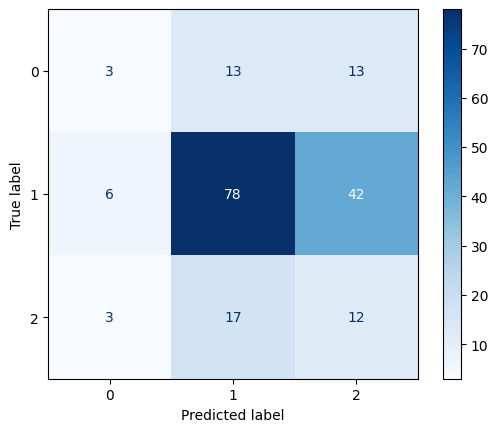

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")


In [26]:
wandb.log(eval_results)